# `mle-hyperopt`: Lightweight Hyperparameter Optimization
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: October 2021] [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/mle-logging/blob/main/examples/getting_started.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

#!pip install -q mle-hyperopt

In [2]:
def fake_train(lrate, batch_size, arch):
    """ Optimum: lrate=0.2, batch_size=4, arch='conv'."""
    f1 = ((lrate - 0.2) ** 2 + (batch_size - 4) ** 2
          + (0 if arch == "conv" else 10))
    return f1

## Basic API Usage: Grid Search

Note that the API assumes that we are minimizing an objective. If you want to maximize simply multiply all objective values with minus 1.

In [3]:
from mle_hyperopt import GridSearch
# Instantiate grid search class
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "spacing": 1}},
                      categorical={"arch": ["mlp", "cnn"]})

# Simple ask - eval - tell API
configs = strategy.ask(batch_size=2)
values = [fake_train(**c) for c in configs]

In [4]:
strategy.tell(configs, values)
configs, values

([{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1},
  {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2}],
 [19.009999999999998, 19.0])

### Saving and reloading previous search results

In [5]:
# Storing of results to .pkl
strategy.save("search_log.json")

Stored 2 search iterations.


In [6]:
# Reloading of results from .pkl
strategy.load("search_log.json")

{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1} was previously evaluated.
{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2} was previously evaluated.
Reloaded 0 previous search iterations.


In [7]:
strategy.log

[{'eval_id': 0,
  'params': {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1},
  'objective': 19.009999999999998},
 {'eval_id': 1,
  'params': {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2},
  'objective': 19.0}]

In [8]:
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "spacing": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      reload_path="search_log.json")

Reloaded 2 previous search iterations.


### Inspecting the search results

In [9]:
# Return flattened log as pandas dataframe
strategy.to_df()

,eval_id,objective,arch,batch_size,lrate
0,0,19.01,mlp,1,0.1
1,1,19.00,mlp,1,0.2


In [10]:
# Retrieving the best performing configuration
strategy.get_best()

({'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2}, 19.0)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

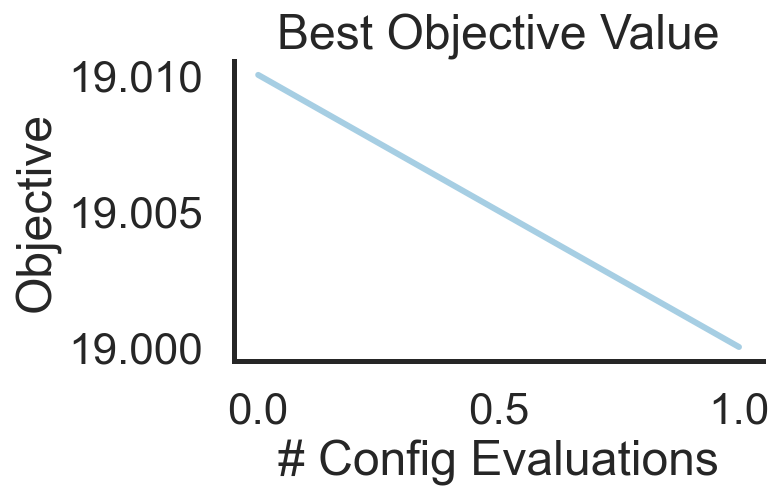

In [11]:
# Plot timeseries of best performing score over search iterations
strategy.plot_best()

### Adding fixed parameters & storing configuration files

In [12]:
strategy = GridSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "bins": 5}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "spacing": 1}},
                      categorical={"arch": ["mlp", "cnn"]},
                      fixed_params={"momentum": 0.9})
strategy.ask(2, store=True)

([{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1, 'momentum': 0.9},
  {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2, 'momentum': 0.9}],
 ['eval_0.yaml', 'eval_1.yaml'])

## Single-Objective: Random Search

In [18]:
from mle_hyperopt import RandomSearch

strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "log-uniform"}},
                        categorical={"arch": ["mlp", "cnn"]},
                        search_config={"refine_after": 5,
                                       "refine_top_k": 2})

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

Refined the random search space:
Real: {'lrate': {'begin': 0.12256463161084011, 'end': 0.34044600469728353, 'prior': 'uniform'}}
Integer: {'batch_size': {'begin': 3, 'end': 3, 'prior': 'log-uniform'}}
Categorical: {'arch': ['cnn', 'mlp']}


In [19]:
strategy.get_best(2)

([{'arch': 'cnn', 'lrate': 0.12256463161084011, 'batch_size': 3},
  {'arch': 'mlp', 'lrate': 0.34044600469728353, 'batch_size': 3}],
 [11.005996236277564, 11.01972508023543])

In [20]:
strategy.print_ranking(4)

11.005996236277564 {'arch': 'cnn', 'lrate': 0.12256463161084011, 'batch_size': 3}
11.01972508023543 {'arch': 'mlp', 'lrate': 0.34044600469728353, 'batch_size': 3}
14.003601204141411 {'arch': 'mlp', 'lrate': 0.13998996632720118, 'batch_size': 2}
19.019450038176412 {'arch': 'cnn', 'lrate': 0.3394633936788146, 'batch_size': 1}


## Single-Objective: Sequential Model-Based Optimization (SMBO)

In [23]:
from mle_hyperopt import SMBOSearch

strategy = SMBOSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                      integer={"batch_size": {"begin": 1,
                                              "end": 5,
                                              "prior": "uniform"}},
                      search_config={"base_estimator": "GP",
                                     "acq_function": "gp_hedge",
                                     "n_initial_points": 5},
                      fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

In [24]:
strategy.print_ranking(4)

10.00047460035985 {'lrate': 0.2217853244146025, 'batch_size': 4}
11.001629941498324 {'lrate': 0.24037253395965763, 'batch_size': 5}
11.00410132442248 {'lrate': 0.26404158354132556, 'batch_size': 5}
11.028243887749536 {'lrate': 0.3680591793075739, 'batch_size': 3}


## Multi-Objective: `nevergrad`

In [25]:
from mle_hyperopt import NevergradSearch

strategy = NevergradSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                           integer={"batch_size": {"begin": 1,
                                                   "end": 5,
                                                   "prior": "uniform"}},
                           search_config={"optimizer": "NGOpt",
                                          "budget_size": 100,
                                          "num_workers": 5},
                           fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.print_ranking(4)

10.007950635596433 {'lrate': 0.28916633667720637, 'batch_size': 4}
10.008013041360774 {'lrate': 0.2895155928359631, 'batch_size': 4}
11.013744720679483 {'lrate': 0.3172378807360612, 'batch_size': 3}
14.001287002274633 {'lrate': 0.16412518606830023, 'batch_size': 2}


In [26]:
def multi_fake_train(lrate, batch_size, arch):
    # optimal for learning_rate=0.2, batch_size=4, architecture="conv"
    f1 = ((lrate - 0.2) ** 2 + (batch_size - 4) ** 2
          + (0 if arch == "conv" else 10))
    # optimal for learning_rate=0.3, batch_size=2, architecture="mlp"
    f2 = ((lrate - 0.3) ** 2 + (batch_size - 2) ** 2
          + (0 if arch == "mlp" else 5))
    return f1, f2

In [27]:
strategy = NevergradSearch(real={"lrate": {"begin": 0.1,
                                      "end": 0.5,
                                      "prior": "uniform"}},
                           integer={"batch_size": {"begin": 1,
                                                   "end": 5,
                                                   "prior": "uniform"}},
                           search_config={"optimizer": "NGOpt",
                                          "budget_size": 100,
                                          "num_workers": 5},
                           fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
values = [multi_fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0,
  'params': {'lrate': 0.2895155928359631, 'batch_size': 4},
  'objective': (10.008013041360774, 9.00010992279358)},
 {'eval_id': 1,
  'params': {'lrate': 0.27813231046267645, 'batch_size': 2},
  'objective': (14.006104657938236, 5.000478195845701)},
 {'eval_id': 2,
  'params': {'lrate': 0.16412518606830023, 'batch_size': 2},
  'objective': (14.001287002274633, 5.018461965060974)},
 {'eval_id': 3,
  'params': {'lrate': 0.3172378807360612, 'batch_size': 3},
  'objective': (11.013744720679483, 6.00029714453227)},
 {'eval_id': 4,
  'params': {'lrate': 0.28916633667720637, 'batch_size': 4},
  'objective': (10.007950635596433, 9.000117368260991)}]

In [28]:
strategy.print_ranking()

[10.00795064  9.00011737] {'lrate': 0.28916633667720637, 'batch_size': 4}
[10.00801304  9.00010992] {'lrate': 0.2895155928359631, 'batch_size': 4}
[11.01374472  6.00029714] {'lrate': 0.3172378807360612, 'batch_size': 3}
[14.001287    5.01846197] {'lrate': 0.16412518606830023, 'batch_size': 2}
[14.00610466  5.0004782 ] {'lrate': 0.27813231046267645, 'batch_size': 2}


## Coordinate-Wise Search

Start scanning one parameter for fixed others and a fixed budget. Afterwards, fix the optimized parameter to best value and go over to next parameter. Repeat until all parameters are done. `search_config` specifies order of parameters and their default. Internally, we run a coordinate-wise grid search.

In [37]:
from mle_hyperopt import CoordinateSearch
strategy = CoordinateSearch(real={"lrate": {"begin": 0.1,
                                            "end": 0.5,
                                            "bins": 5}},
                            integer={"batch_size": {"begin": 1,
                                                    "end": 5,
                                                    "spacing": 1}},
                            search_config={"order": ["lrate", "batch_size"],
                                           "defaults": {"lrate": 0.1,
                                                        "batch_size": 3}},
                            fixed_params={"arch": "cnn"})

configs = strategy.ask(5)
configs

[{'batch_size': 3, 'lrate': 0.1, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.2, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.30000000000000004, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.4, 'arch': 'cnn'},
 {'batch_size': 3, 'lrate': 0.5, 'arch': 'cnn'}]

In [38]:
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0, 'params': {'batch_size': 3, 'lrate': 0.1}, 'objective': 11.01},
 {'eval_id': 1, 'params': {'batch_size': 3, 'lrate': 0.2}, 'objective': 11.0},
 {'eval_id': 2,
  'params': {'batch_size': 3, 'lrate': 0.30000000000000004},
  'objective': 11.01},
 {'eval_id': 3, 'params': {'batch_size': 3, 'lrate': 0.4}, 'objective': 11.04},
 {'eval_id': 4, 'params': {'batch_size': 3, 'lrate': 0.5}, 'objective': 11.09}]

In [39]:
configs = strategy.ask(4)
configs

[{'batch_size': 1, 'lrate': 0.2, 'arch': 'cnn'},
 {'batch_size': 2, 'lrate': 0.2, 'arch': 'cnn'},
 {'batch_size': 4, 'lrate': 0.2, 'arch': 'cnn'},
 {'batch_size': 5, 'lrate': 0.2, 'arch': 'cnn'}]

In [40]:
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0, 'params': {'batch_size': 3, 'lrate': 0.1}, 'objective': 11.01},
 {'eval_id': 1, 'params': {'batch_size': 3, 'lrate': 0.2}, 'objective': 11.0},
 {'eval_id': 2,
  'params': {'batch_size': 3, 'lrate': 0.30000000000000004},
  'objective': 11.01},
 {'eval_id': 3, 'params': {'batch_size': 3, 'lrate': 0.4}, 'objective': 11.04},
 {'eval_id': 4, 'params': {'batch_size': 3, 'lrate': 0.5}, 'objective': 11.09},
 {'eval_id': 5, 'params': {'batch_size': 1, 'lrate': 0.2}, 'objective': 19.0},
 {'eval_id': 6, 'params': {'batch_size': 2, 'lrate': 0.2}, 'objective': 14.0},
 {'eval_id': 7, 'params': {'batch_size': 4, 'lrate': 0.2}, 'objective': 10.0},
 {'eval_id': 8, 'params': {'batch_size': 5, 'lrate': 0.2}, 'objective': 11.0}]

In [41]:
configs = strategy.ask(5)
configs

[]

In [42]:
strategy.all_evaluated_params

[{'batch_size': 3, 'lrate': 0.1},
 {'batch_size': 3, 'lrate': 0.2},
 {'batch_size': 3, 'lrate': 0.30000000000000004},
 {'batch_size': 3, 'lrate': 0.4},
 {'batch_size': 3, 'lrate': 0.5},
 {'batch_size': 1, 'lrate': 0.2},
 {'batch_size': 2, 'lrate': 0.2},
 {'batch_size': 4, 'lrate': 0.2},
 {'batch_size': 5, 'lrate': 0.2}]

# `hyperopt` decorator - minimal search wrapper

Note: Assumes that function to evaluate directly consumes a configuration dictionary.

In [60]:
from mle_hyperopt import hyperopt

@hyperopt(strategy_type="grid",
          num_search_iters=400,
          real={"x": {"begin": -0.5, "end": 0.5, "bins": 20},
                "y": {"begin": -0.5, "end": 0.5, "bins": 20}})
def circle_objective(config):
    distance = abs((config["x"] ** 2 + config["y"] ** 2))
    return distance

strategy = circle_objective()
len(strategy)

400

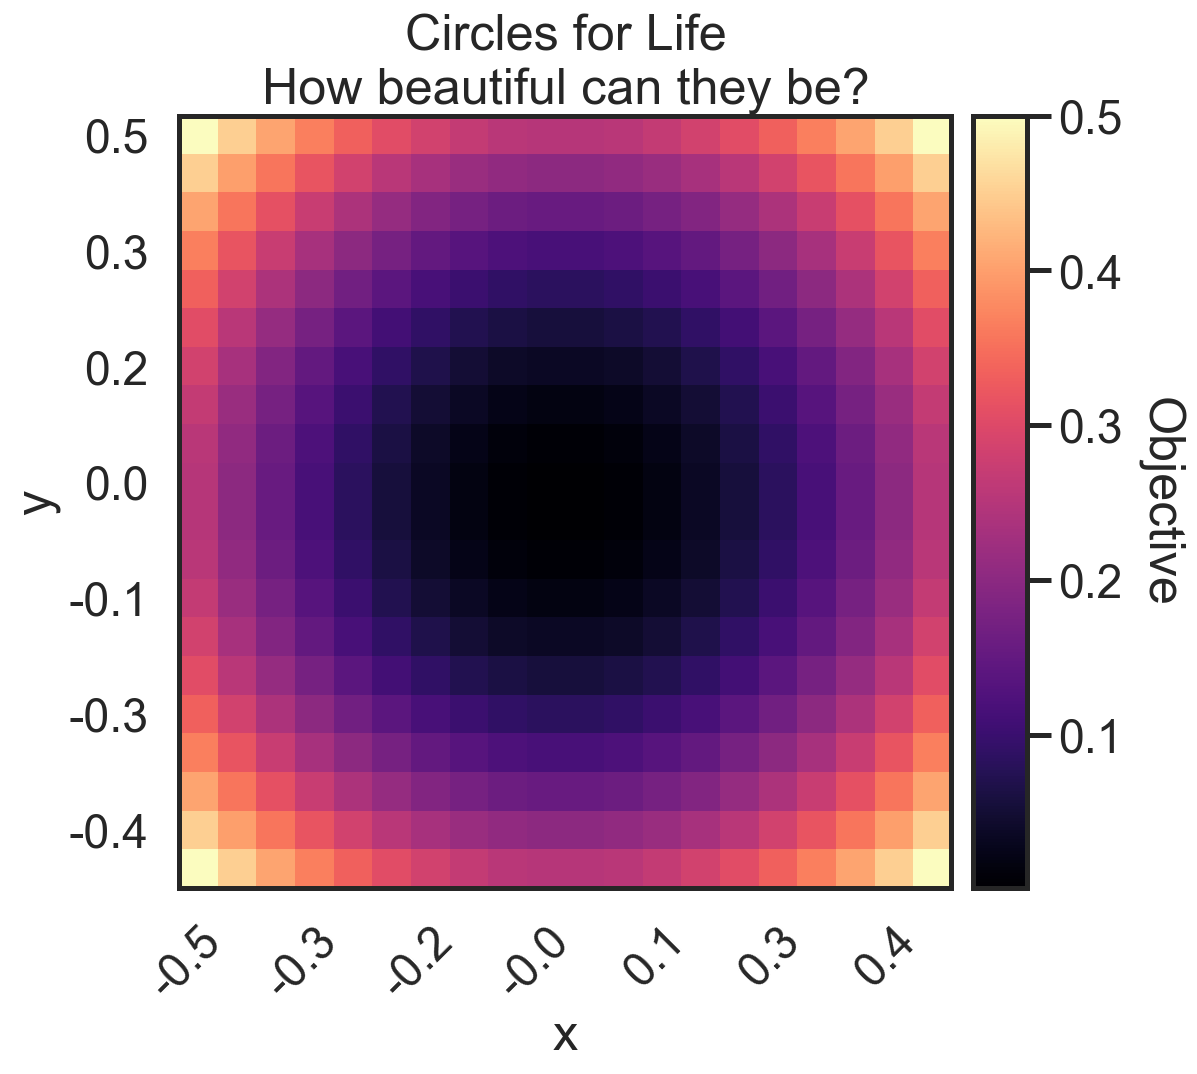

In [64]:
strategy.plot_grid(params_to_plot=["x", "y"],
                   target_to_plot="objective",
                   plot_title="Circles for Life",
                   plot_subtitle="How beautiful can they be?",
                   xy_labels= ["x", "y"],
                   variable_name="Objective",
                   every_nth_tick=3)